This is a Image Classification Project by using Kaggle Intel Image Dataset(https://www.kaggle.com/datasets/puneet6060/intel-image-classification).

Import libraries, frameworks and packages.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [80]:
# plot style and warnings

plt.style.use('classic')

import warnings
warnings.filterwarnings('ignore')

Data preparation.

In [3]:
# define image shape variable

IMAGE_SHAPE = (75,75)

# define dataset as path

train = pathlib.Path('./dataset/seg_train/seg_train')
test = pathlib.Path('./dataset/seg_test/seg_test/')
print(train)

# print photos
print(list(train.glob('*/*.jpg'))[:5])

counter_image_train = len(list(train.glob('*/*.jpg')))
counter_image_test = len(list(test.glob('*/*.jpg')))

print(f'Train images total are: {counter_image_train}')
print(f'Test images total are: {counter_image_test}')

dataset/seg_train/seg_train
[PosixPath('dataset/seg_train/seg_train/sea/8375.jpg'), PosixPath('dataset/seg_train/seg_train/sea/3327.jpg'), PosixPath('dataset/seg_train/seg_train/sea/7365.jpg'), PosixPath('dataset/seg_train/seg_train/sea/14407.jpg'), PosixPath('dataset/seg_train/seg_train/sea/19224.jpg')]
Train images total are: 14034
Test images total are: 3000


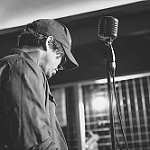

In [4]:
# splitting to categories
# train

category_images_dict_train = {
    'buildings':list(train.glob('buildings/*')),
    'forest':list(train.glob('forest/*')),
    'glacier':list(train.glob('glacier/*')),
    'mountain':list(train.glob('mountain/*')),
    'sea':list(train.glob('sea/*')),
    'street':list(train.glob('street/*'))
}

# test

category_images_dict_test = {
    'buildings':list(test.glob('buildings/*')),
    'forest':list(test.glob('forest/*')),
    'glacier':list(test.glob('glacier/*')),
    'mountain':list(test.glob('mountain/*')),
    'sea':list(test.glob('sea/*')),
    'street':list(test.glob('street/*'))
}

# labeling data

label_dict = {
    'buildings':0,
    'forest':1,
    'glacier':2,
    'mountain':3,
    'sea':4,
    'street':5
}

# showing one image from glacier category

Image.open(str(category_images_dict_train['glacier'][0]))


           Train  Test
buildings   2191   437
forest      2271   474
glacier     2404   553
mountain    2512   525
sea         2274   510
street      2382   501


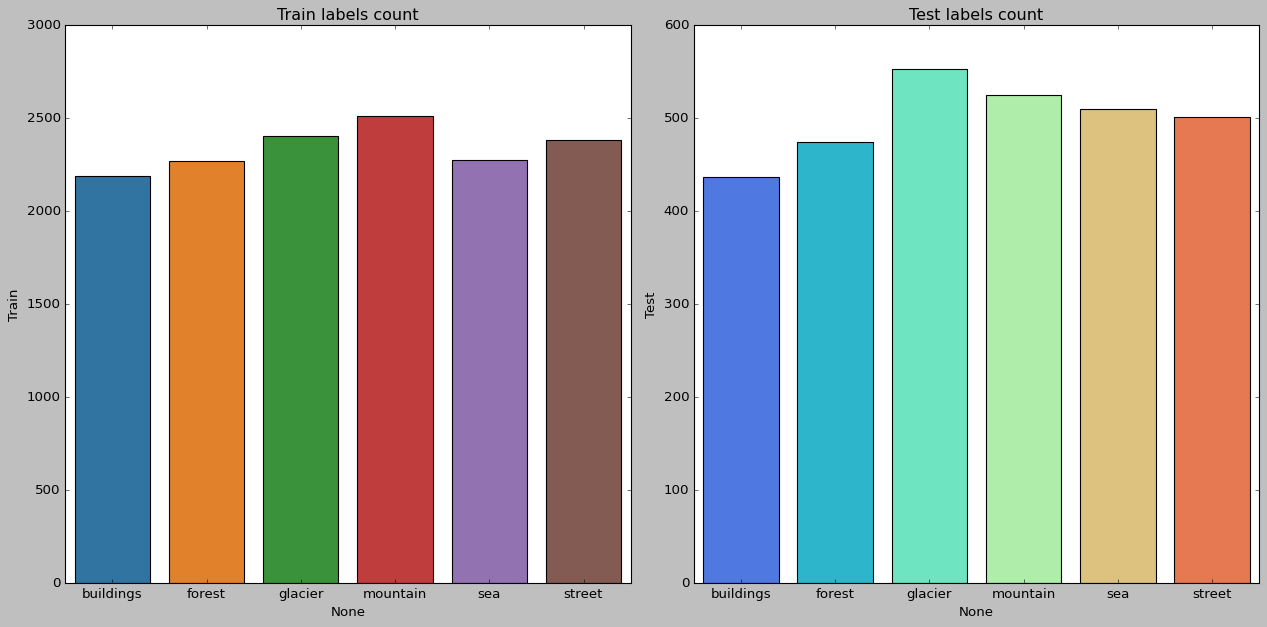

In [81]:
# looking to count of labels

train_series = pd.Series({key: len(value) for key, value in category_images_dict_train.items()}, index = category_images_dict_train.keys())
test_series = pd.Series({key: len(value) for key, value in category_images_dict_test.items()}, index = category_images_dict_test.keys())
count_df = pd.concat([train_series, test_series], axis = 1).rename(columns = {0:'Train', 1:'Test'})
print(count_df)

# plot results
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.barplot(data = count_df, x = count_df.index, y = 'Train', palette = 'tab10')
plt.title('Train labels count')
plt.subplot(1,2,2)
sns.barplot(data = count_df, x = count_df.index, y = 'Test', palette = 'rainbow')
plt.title('Test labels count')
plt.tight_layout()
plt.show();

We have some disbalance in our data, but it is not critical.

In [5]:
# we need to convert our images into numpy arrays, we will use cv2 module to do that

def to_numpy_array(category_dict: dict, label_dict: dict) -> np.array:
    X, y = [], []
    for category, images in category_dict.items():
        for image in images:
            img = cv2.imread(str(image))
            resized_image = cv2.resize(img, IMAGE_SHAPE)
            X.append(resized_image)
            y.append(label_dict[category])
    return np.array(X), np.array(y)

In [6]:
# X and y, spliting for validation
X_train, y_train = to_numpy_array(category_images_dict_train, label_dict)
X_test, y_test = to_numpy_array(category_images_dict_test, label_dict)
# validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)


In [7]:
# looking through shapes

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (12630, 75, 75, 3)
X_test shape: (3000, 75, 75, 3)
X_val shape: (1404, 75, 75, 3)
y_train shape: (12630,)
y_test shape: (3000,)
y_val shape: (1404,)


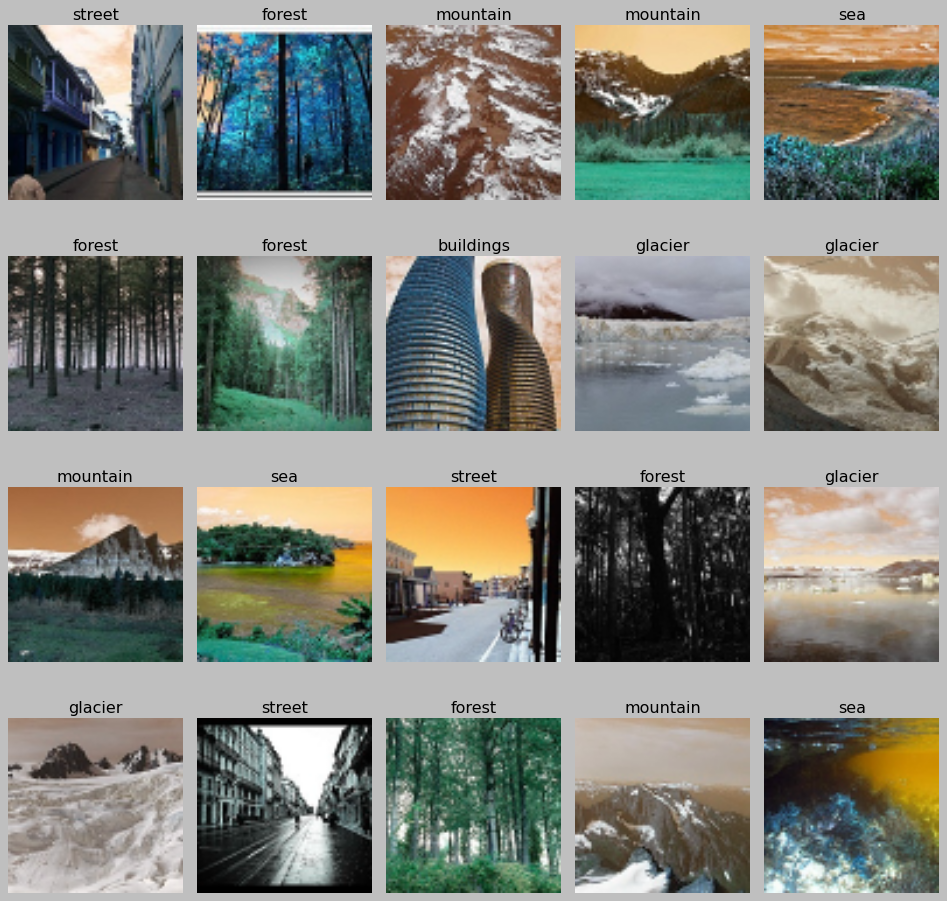

In [30]:
# looking through images
# function to get keys from label_dict
def get_key(label: int, label_dict = label_dict) -> str:
    for key, value in label_dict.items():
        if label == value:
            return key

plt.figure(figsize = (12,12))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(get_key(label = y_train[i]))
plt.tight_layout()
plt.show();

In [10]:
# scale data by dividing to 255(RGB channel maximum value)

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
X_val_scaled = X_val / 255

# hot encoding of y-s
y_train_hot = keras.utils.to_categorical(y_train, num_classes = 6)
y_test_hot = keras.utils.to_categorical(y_test, num_classes = 6)
y_val_hot = keras.utils.to_categorical(y_val, num_classes = 6)
print(f'y_train shape after hot encoding: {y_train_hot.shape}')
print(X_train_scaled)

y_train shape after hot encoding: (12630, 6)
[[[[0.13333333 0.17254902 0.2       ]
   [0.1254902  0.16862745 0.18431373]
   [0.14117647 0.18431373 0.2       ]
   ...
   [0.39215686 0.46666667 0.52941176]
   [0.40784314 0.47843137 0.52156863]
   [0.39215686 0.4627451  0.49411765]]

  [[0.11764706 0.15686275 0.18431373]
   [0.13333333 0.17647059 0.19215686]
   [0.10980392 0.15294118 0.16862745]
   ...
   [0.41176471 0.49411765 0.55686275]
   [0.37647059 0.44705882 0.49803922]
   [0.38039216 0.44313725 0.48235294]]

  [[0.11764706 0.16470588 0.18823529]
   [0.12156863 0.16470588 0.18039216]
   [0.12941176 0.17254902 0.18823529]
   ...
   [0.36470588 0.47058824 0.53333333]
   [0.38431373 0.4745098  0.5254902 ]
   [0.37254902 0.44705882 0.49019608]]

  ...

  [[0.24705882 0.2        0.17647059]
   [0.41568627 0.35294118 0.31764706]
   [0.32156863 0.24705882 0.20392157]
   ...
   [0.24313725 0.22352941 0.19215686]
   [0.19215686 0.18039216 0.15686275]
   [0.10980392 0.10588235 0.09019608]]



Scaled predictors and categorical classes have much better perfomance in ML.

Building model.

We will use CNN layers in our Neural Network.

In [11]:
myNN = keras.Sequential([
   layers.experimental.preprocessing.RandomZoom(0.3),
   layers.experimental.preprocessing.RandomContrast(0.3),
   layers.experimental.preprocessing.RandomFlip(mode = 'vertical'),
   layers.Conv2D(input_shape = IMAGE_SHAPE + (3,), kernel_size = (3, 3), activation = 'relu', filters = 16, padding = 'same'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(kernel_size = (3, 3), activation = 'relu', filters = 32, padding = 'same'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(kernel_size = (3, 3), activation = 'relu', filters = 64, padding = 'same'),
   layers.MaxPooling2D((2,2)),
   layers.Flatten(),
   layers.Dense(128, activation = 'relu'),
   layers.Dropout(0.2),
   layers.Dense(64, activation = 'relu'),
   layers.Dense(32, activation = 'relu'),
   layers.Dense(6, activation = 'softmax')
])

myNN.compile(optimizer = 'adam',
               loss = keras.losses.CategoricalCrossentropy(from_logits = False),
               metrics = ['accuracy'])

model_history = myNN.fit(X_train_scaled, y_train_hot, validation_data = (X_val_scaled, y_val_hot), epochs = 50)

2023-11-06 17:53:09.841450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 17:53:09.911505: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 17:53:09.911557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 17:53:09.916506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 17:53:09.916566: I tensorflow/compile

Epoch 1/50


2023-11-06 17:53:16.171708: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 17:53:16.773981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-06 17:53:17.077174: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 17:53:18.012928: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5fc4148b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 17:53:18.012974: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-11-06 17:53:18.029143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 17:53:18.147409: I ./tensorflow/compiler/j

395/395 [==============================] - 11s 14ms/step - loss: 1.2488 - accuracy: 0.4738 - val_loss: 1.0592 - val_accuracy: 0.5726
Epoch 2/50
395/395 [==============================] - 5s 12ms/step - loss: 1.0138 - accuracy: 0.5946 - val_loss: 0.9449 - val_accuracy: 0.6147
Epoch 3/50
395/395 [==============================] - 5s 13ms/step - loss: 0.9098 - accuracy: 0.6496 - val_loss: 0.8423 - val_accuracy: 0.6802
Epoch 4/50
395/395 [==============================] - 5s 12ms/step - loss: 0.8437 - accuracy: 0.6769 - val_loss: 0.8016 - val_accuracy: 0.7001
Epoch 5/50
395/395 [==============================] - 5s 12ms/step - loss: 0.7904 - accuracy: 0.7015 - val_loss: 0.7020 - val_accuracy: 0.7293
Epoch 6/50
395/395 [==============================] - 5s 12ms/step - loss: 0.7563 - accuracy: 0.7180 - val_loss: 0.7267 - val_accuracy: 0.7286
Epoch 7/50
395/395 [==============================] - 5s 12ms/step - loss: 0.7217 - accuracy: 0.7344 - val_loss: 0.6982 - val_accuracy: 0.7308
Epoch 8/5

In [12]:
myNN.evaluate(X_test_scaled, y_test_hot)

94/94 [==============================] - 1s 6ms/step - loss: 0.5781 - accuracy: 0.8197


[0.5781244039535522, 0.8196666836738586]

Train has ~89%, test ~82% and validation around 80% accuracy results.

Pretty good in my thought, it's like average results.

In [79]:
myNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 75, 75, 3)         0         
                                                                 
 random_contrast (RandomCon  (None, 75, 75, 3)         0         
 trast)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 75, 75, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 37, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4

In [13]:
# predict values

predictions = myNN.predict(X_test_scaled)
y_pred = [np.argmax(elem) for elem in predictions]
print(y_pred)

94/94 [==============================] - 0s 3ms/step
[3, 0, 0, 0, 2, 0, 0, 4, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 4, 0, 0, 5, 3, 0, 5, 5, 0, 5, 5, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 1, 4, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 1, 0, 0, 0, 5, 0, 4, 0, 1, 0, 0, 0, 0, 5, 1, 0, 1, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 5, 0, 0, 0, 3, 4, 0, 0, 5, 5, 4, 0, 0, 0, 0, 0, 0, 5, 5, 0, 5, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0

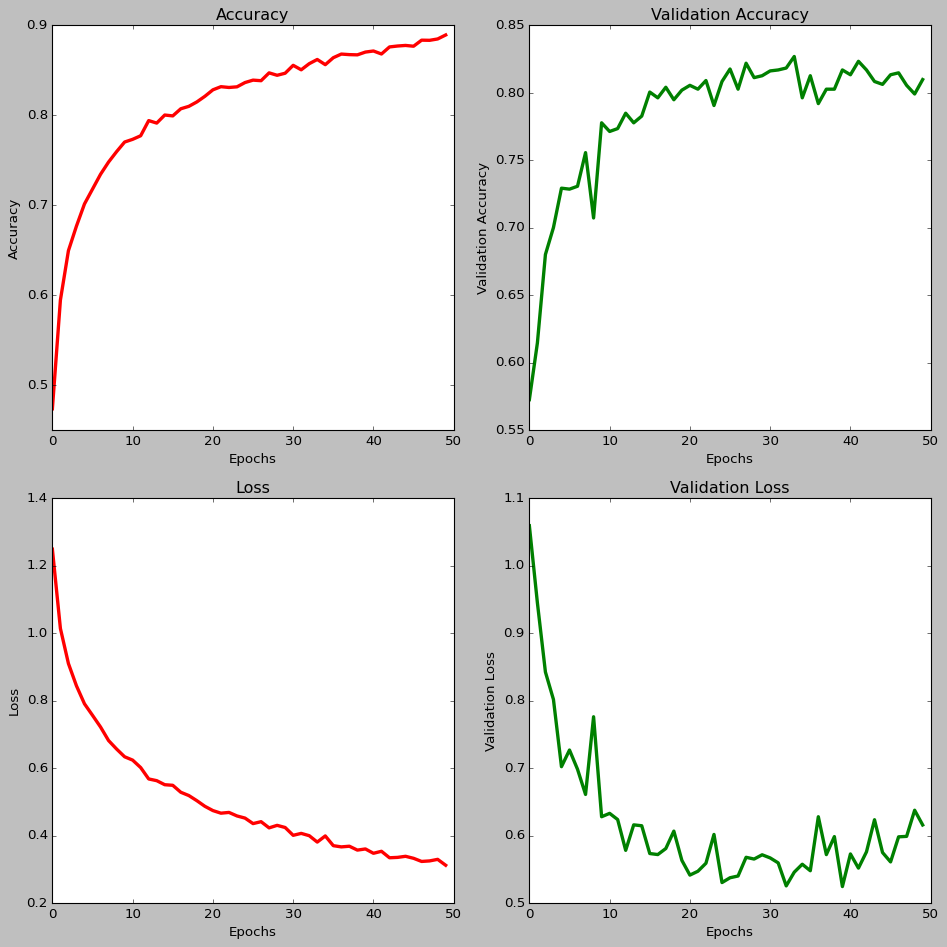

In [56]:
# ploting results
# train accuracy-loss and validation accuracy-loss per epoch plots
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
plot_titles_list = ['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss']
plot_topics_list = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
colors = ['red', 'green']
for ax_i, title in enumerate(plot_titles_list):
    row = ax_i // 2
    col = ax_i % 2
    ax = axes[row, col]
    sns.lineplot(model_history.history[plot_topics_list[ax_i]], ax = ax, color = colors[ax_i % 2], lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(plot_titles_list[ax_i])
    ax.set_title(plot_titles_list[ax_i])
plt.tight_layout()
plt.show();

Let's make classification report and confussion matrix.

              precision    recall  f1-score   support

   buildings       0.81      0.80      0.80       437
      forest       0.90      0.98      0.94       474
     glacier       0.80      0.76      0.78       553
    mountain       0.81      0.69      0.75       525
         sea       0.76      0.90      0.82       510
      street       0.85      0.80      0.83       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



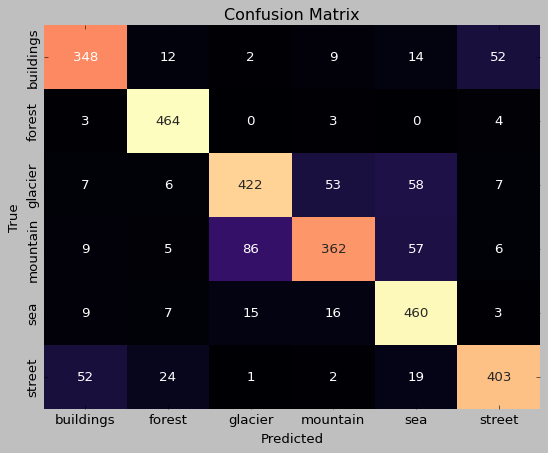

In [54]:
label_names = []
for i in range(6):
    label_names.append(get_key(label = i))

print(classification_report(y_test, y_pred, target_names = label_names))

sns.heatmap(data = confusion_matrix(y_test, y_pred), xticklabels = label_names, yticklabels = label_names,
            cmap = 'magma', cbar = False, annot = True, fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

We have done all goals for this dataset.We have pretty good scores for all our data splits.Most problematic labels were mountains and glaciers, due our observations, glaciers have similiar notes with sea, and mountains have similiar notes with forests in some cases.